In [1]:
# In this notebook, we use the Machine Learning model which has been already developed
# to try and predict the parameters c10 and c01 of the Mooney Rivilin model from the
# respective stress-strain curves

# The number of increments for each curve has been greatly reduced.
# The number of combinations of c10 and c01 has been increased.

# Should have added some noise to the stress data. Will later update the notebook.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ast
import seaborn as sns
from sklearn.model_selection import train_test_split

import pandas as pd
import random
import sympy as sym
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [2]:
def mooney_rivlin_equibiaxial(params, stretch):
    #returns cauchy stress at xx direction (stressxx == stressyy)
    
    # Right Cauchy-Green Deformation Tensor 'C'
    C11 = sym.Symbol('C11')
    C22 = sym.Symbol('C22')
    C33 = sym.Symbol('C33')
    C = sym.Matrix([[C11,0,0], [0,C22,0], [0,0,C33]])  
    
    # Compute the invariants I1 and I2 of the tensor C
    i1=sym.trace(C)
    i2 = C11*C22 + C22*C33 + C33*C11
    
    #Generate SEF (Strain Energy Function)
    #symbolic C10 and C01
    c10s = sym.Symbol('c10s')
    c01s = sym.Symbol('c01s')
    sef=c10s*(i1-3) + c01s*(i2-3)
    #Second Piola Kirchoff Stresses
    S11=2*sym.diff(sef,C11)
    S22=2*sym.diff(sef,C22)
    S33=2*sym.diff(sef,C33)
    S = sym.Matrix([[S11,0,0], [0,S22,0], [0,0,S33]])
    
    # Deformation Gradient assuming incompressibility and a equibiaxial load
    F=sym.Matrix([[stretch,0,0], [0,stretch,0], [0,0,1/(stretch**2)]])
    Ft=sym.transpose(F)
    C=Ft*F

    C11v=C[0,0]
    C22v=C[1,1]
    C33v=C[2,2]
    
    cauchy=(F*S*Ft) # push-forward. cauchy stresses with no BCs
    stress=cauchy[0,0]-cauchy[2,2] # imposing of boundary conditions
    stress_abq=sym.Matrix([[stress,0,0], [0, stress,0], [0,0,0]]) # stress11 == stress22; stress33 == 0
    s11_val=stress_abq.subs([(C11, C11v), (C22, C22v), (C33, C33v), (c10s,params[0]), (c01s,params[1])])
    np.array(s11_val).astype(np.float64)
    
    return s11_val[0,0]

# The function now only returns s11_val[0,0]. This is because I
# will not include the values of stretch at this point in the Machine Learning model. 
# All stress vectors (y) are for the same stretch vectors (x), linearly spaced from st_min to st_max.

def get_curve(params,stretch_min,stretch_max,ninc):
    #stores Mooney-Rivlin equibiaxial runs between minimum and a maximum stretch
    lst=[mooney_rivlin_equibiaxial(params, stretch) for stretch in np.linspace(stretch_min,stretch_max,ninc)]
    return lst

In [3]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [4]:
#Initial data-----------------------------------------------------------------------------------------------------

C10min=0.1     #min C10 value
C10max=10.0    #max C10 value
C01min=0.1     #min C01 value
C01max=2.0     #max C01 value
decimals=2   #number of decimal cases of C10 and C01 variables

n_c10=20             #number of C10 variables
n_c01=20             #number of C01 variables
n = n_c10 * n_c01     #number of combinations
#
st_max=3.0             #applied stretch
st_min=1.0
ninc=25       #number of stretch increments
#------------------------------------------------------------------------------------------------------------------

In [5]:
# Generates random values for c10 and c01
c10_list = np.round(np.random.uniform(C10min, C10max, size=(n_c10, 1)), decimals)
c01_list = np.round(np.random.uniform(C01min, C01max, size=(n_c01, 1)), decimals)
params = np.array([])

# Computes the n combinations of c10 and c01 values
for i in c10_list:
    for j in c01_list:
        params = np.append(params, np.array([i,j]))
params = params.reshape(-1, 2)

In [42]:
# Append the combinations to a DataFrame

df = pd.DataFrame(params[:,0], columns = ['c10'])
df['c01'] = params[:,1]

# Later I will deal with duplicates

In [7]:
#generate (x,y) data for each unique c10 at the dataframe
df['data']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc), axis=1)
df[0:10]

,c10,c01,data
0,6.1,1.19,"[0, 6.71074560764543, 12.6809718108710, 18.352..."
1,6.1,0.70,"[0, 6.19595941412326, 11.5854008232167, 16.587..."
2,6.1,1.48,"[0, 7.01541498748508, 13.3293709668297, 19.397..."
3,6.1,0.19,"[0, 5.66016153923284, 10.4451126523928, 14.749..."
4,6.1,1.72,"[0, 7.26755516390411, 13.8659771648644, 20.262..."
5,6.1,1.10,"[0, 6.61619304148830, 12.4797444866080, 18.028..."
6,6.1,1.32,"[0, 6.84732153653907, 12.9716335014732, 18.821..."
7,6.1,1.82,"[0, 7.37261357074537, 14.0895630807123, 20.622..."
8,6.1,0.27,"[0, 5.74420826470585, 10.6239813850710, 15.038..."
9,6.1,0.20,"[0, 5.67066737991697, 10.4674712439776, 14.785..."


In [8]:
# This step is necessary because the Keras model won't accept sympy.core.numbers.Float type values.

for i in range(df.shape[0]):
    for j in range(ninc):
        df.data[i][j] = float(df.data[i][j])

In [9]:
test_split = 0.1 #we will use 10% of the data for testing.
train_df, test_df = train_test_split(df, test_size = test_split)

#the training data will be spllited automatically by 80/20 during training using keras framework. 

In [10]:
# Let's check the array shapes: 
print('Training set: ',train_df.shape)
print('Test set: ',test_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

Training set:  (360, 3)
Test set:  (40, 3)


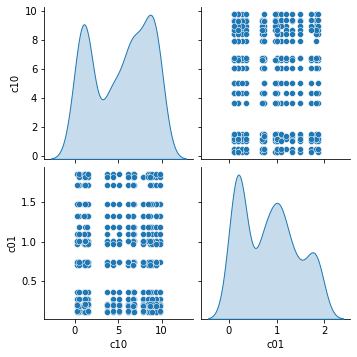

In [11]:
#inspect the training dataset
sns.pairplot(train_df[['c10','c01']], diag_kind='kde')

In [12]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
c10,360.0,5.271944,3.303035,0.28,1.39,6.10,8.4000,9.78
c01,360.0,0.839861,0.581124,0.10,0.20,0.74,1.2225,1.86


In [13]:
# Allocate the features and the labels in different DataFrames.

train_features = train_df.copy()
test_features = test_df.copy()

train_labels = pd.DataFrame([train_features.pop('c10'), train_features.pop('c01')])
train_labels = train_labels.T
test_labels = pd.DataFrame([test_features.pop('c10'), test_features.pop('c01')])
test_labels = test_labels.T

In [14]:
feature_columns = []

# Will not include the values of x (in this case stretch) at this point. 
# All stress vectors (y) are for the same stretch vectors (x), linearly spaced from st_min to st_max.

y_col = tf.feature_column.numeric_column("data")
feature_columns.append(y_col)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [ ]:
# Build the model and define its architecture.

In [18]:
inputs = keras.Input(shape=ninc)

dense = layers.Dense(512, activation="relu")
x = dense(inputs)

x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(2)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="model")

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense (Dense)                (None, 512)               13312     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 276,994
Trainable params: 276,994
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Set the hyperparameters

validation_split = 0.2
learning_rate = 0.0001
batch_size = 50
epochs = 30

In [21]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

In [22]:
# Convert the data arrays into tensors.

tf_train_features = tf.constant([train_features['data']], shape=(train_size,ninc))

tf_train_labels = tf.constant([np.array(train_labels)], shape=(train_size,2))

tf_test_features = tf.constant([np.array(test_features['data'])], shape=(test_size,ninc))

tf_test_labels = tf.constant([np.array(test_labels)], shape=(test_size,2))

In [23]:
history = model.fit(tf_train_features, tf_train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

test_scores = model.evaluate(tf_train_features, tf_train_labels, verbose=2)
print("Test loss:", test_scores)

Epoch 1/30
6/6 [==============================] - 1s 47ms/step - loss: 20.2012 - val_loss: 14.3615
Epoch 2/30
6/6 [==============================] - 0s 12ms/step - loss: 8.1915 - val_loss: 8.2937
Epoch 3/30
6/6 [==============================] - 0s 14ms/step - loss: 3.6510 - val_loss: 2.4264
Epoch 4/30
6/6 [==============================] - 0s 11ms/step - loss: 1.4687 - val_loss: 0.3948
Epoch 5/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6851 - val_loss: 0.0631
Epoch 6/30
6/6 [==============================] - 0s 13ms/step - loss: 0.3638 - val_loss: 0.3071
Epoch 7/30
6/6 [==============================] - 0s 15ms/step - loss: 0.2256 - val_loss: 0.2582
Epoch 8/30
6/6 [==============================] - 0s 14ms/step - loss: 0.1415 - val_loss: 0.0442
Epoch 9/30
6/6 [==============================] - 0s 13ms/step - loss: 0.0618 - val_loss: 0.0647
Epoch 10/30
6/6 [==============================] - 0s 13ms/step - loss: 0.0522 - val_loss: 0.0500
Epoch 11/30
6/6 [==========

8.293227086775005


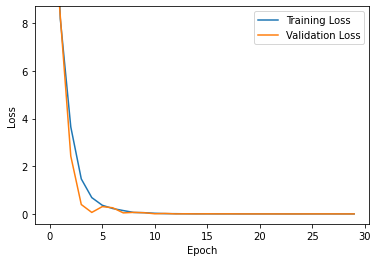

In [24]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [25]:
tf_test_labels

<tf.Tensor: shape=(40, 2), dtype=float64, numpy=
array([[6.75, 0.1 ],
       [9.78, 0.74],
       [9.41, 0.74],
       [8.94, 1.32],
       [8.4 , 0.97],
       [0.46, 0.2 ],
       [9.35, 1.19],
       [6.1 , 0.97],
       [5.04, 1.82],
       [9.35, 1.72],
       [6.75, 0.74],
       [9.41, 0.2 ],
       [0.28, 1.82],
       [9.41, 1.01],
       [1.39, 0.35],
       [3.66, 0.27],
       [7.91, 1.86],
       [6.65, 1.48],
       [6.75, 0.97],
       [9.35, 1.86],
       [6.76, 1.32],
       [5.04, 0.7 ],
       [0.46, 0.97],
       [9.41, 1.01],
       [8.71, 1.1 ],
       [7.91, 1.72],
       [6.65, 0.19],
       [8.94, 1.01],
       [1.05, 1.19],
       [6.76, 0.7 ],
       [9.78, 0.7 ],
       [8.94, 0.11],
       [9.41, 0.19],
       [0.28, 1.19],
       [1.55, 1.19],
       [8.4 , 0.74],
       [4.36, 1.1 ],
       [1.39, 0.7 ],
       [6.76, 0.97],
       [8.4 , 1.72]])>

In [26]:
guesses = model.predict(tf_test_features)

guesses

array([[6.7441506 , 0.08271397],
       [9.873716  , 0.6727265 ],
       [9.49615   , 0.67584884],
       [8.97897   , 1.3033322 ],
       [8.422382  , 0.933154  ],
       [0.4619323 , 0.19995226],
       [9.368334  , 1.1766595 ],
       [6.1297913 , 0.9527806 ],
       [5.0553646 , 1.804797  ],
       [9.404422  , 1.6451463 ],
       [6.769273  , 0.7074479 ],
       [9.441291  , 0.18808831],
       [0.3283754 , 1.8447255 ],
       [9.436885  , 0.962901  ],
       [1.4057213 , 0.33528602],
       [3.697262  , 0.24487294],
       [7.999043  , 1.7930039 ],
       [6.7280498 , 1.4348325 ],
       [6.7782574 , 0.95943344],
       [9.42895   , 1.7970818 ],
       [6.813082  , 1.2724484 ],
       [5.0571127 , 0.69186676],
       [0.48593917, 0.95481575],
       [9.436885  , 0.962901  ],
       [8.728013  , 1.0855073 ],
       [8.00407   , 1.6715974 ],
       [6.6651073 , 0.17180528],
       [8.964309  , 0.96908844],
       [1.0785091 , 1.1415557 ],
       [6.781048  , 0.66450584],
       [9.

In [27]:
# relative error (%)

error_mat = (np.abs(tf_test_labels - model.predict(tf_test_features)) / tf_test_labels) * 100

error_mat

<tf.Tensor: shape=(40, 2), dtype=float64, numpy=
array([[ 0.08665721, 17.28603095],
       [ 0.95824493,  9.0910119 ],
       [ 0.91551559,  8.66907545],
       [ 0.43590127,  1.26271139],
       [ 0.2664566 ,  3.79855805],
       [ 0.42006555,  0.02387017],
       [ 0.1960836 ,  1.12105338],
       [ 0.48838131,  1.77519543],
       [ 0.30485335,  0.83532674],
       [ 0.5820514 ,  4.35196217],
       [ 0.28552303,  4.39893426],
       [ 0.33252769,  5.95584363],
       [17.27692825,  1.35854339],
       [ 0.28570542,  4.6632677 ],
       [ 1.13102927,  4.20399393],
       [ 1.01808876,  9.30631757],
       [ 1.12570149,  3.60193996],
       [ 1.17368053,  3.05186123],
       [ 0.4186277 ,  1.08933645],
       [ 0.84438834,  3.38269741],
       [ 0.78523991,  3.60239238],
       [ 0.33953758,  1.16189207],
       [ 5.63895106,  1.56538708],
       [ 0.28570542,  4.6632677 ],
       [ 0.20680871,  1.31752058],
       [ 1.18925767,  2.81410689],
       [ 0.22717669,  9.57616975],
      

In [38]:
error_avg = np.array([0.00,0.00])
error_avg[0] = np.average(error_mat[:,0])
error_avg[1] = np.average(error_mat[:,1])

In [40]:
error_avg # [avg error for c10, avg error for c01]

array([1.44370598, 4.25611507])

In [45]:
np.average(error_mat)

2.849910524730169

In [44]:
np.std(error_mat)

3.612459498789579